In [5]:
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, Flatten
from keras.layers.core import Lambda
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.examples.tutorials.mnist import input_data

In [2]:
mnist = input_data.read_data_sets("F:\\datasets\\MNIST", one_hot=True)
not_mnist = input_data.read_data_sets("F:\\datasets\\notMNIST", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting F:\datasets\MNIST\train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting F:\datasets\MNIST\train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting F:\datasets\MNIST\t10k-images-idx3-ubyte.gz
Extracting F:\datasets\MNIST\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Extracting F:\datasets\notMNIST\train-images-idx3-ubyte.gz
Extracting F:\datasets\notMNIST\train-labels-idx1-ubyte.gz
Extracting F:\datasets\notMNIST\t10k-images-idx3-ubyte.gz
Extracting F:\datasets\notMNIST\t10k-labels-idx1-ubyte.gz


In [8]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten

#create model
model = Sequential()

#add model layers
model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(28,28,1)))
model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))

#compile model using accuracy to measure model performance
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [6]:
# Get Data
x_train_mnist = mnist.train.images.reshape((-1, 28, 28, 1))
y_train_mnist = mnist.train.labels
x_val_mnist = mnist.validation.images.reshape((-1, 28, 28, 1))
y_val_mnist = mnist.validation.labels
x_test_mnist = mnist.test.images.reshape((-1, 28, 28, 1))
y_test_mnist = mnist.test.labels

print(x_val_mnist.shape)
print(x_test_mnist.shape)

x_test_notMNIST = not_mnist.test.images.reshape((-1, 28, 28, 1))

(5000, 28, 28, 1)
(10000, 28, 28, 1)


In [5]:
# MNIST vs notMNIST
model.fit(x_train_mnist, y_train_mnist, validation_data=(x_val_mnist, y_val_mnist), epochs=1)

Train on 55000 samples, validate on 5000 samples
Epoch 1/1
55000/55000 [==============================] - 18s - loss: 0.1327 - acc: 0.9603 - val_loss: 0.0588 - val_acc: 0.9836


### Get predictions for test sets MNIST (in-distribution) and notMNIST (out-of-distribution)

In [7]:
preds = model.predict(x_test_mnist)
preds_ood = model.predict(x_test_notMNIST)

## Using max softmax value as confidence score

In [8]:
confidence = np.amax(preds, axis=1)
confidence_ood = np.amax(preds_ood, axis=1)

In [9]:
bin_dividers = np.linspace(0.0, 1.0, num=71)
print(bin_dividers)

[0.         0.01428571 0.02857143 0.04285714 0.05714286 0.07142857
 0.08571429 0.1        0.11428571 0.12857143 0.14285714 0.15714286
 0.17142857 0.18571429 0.2        0.21428571 0.22857143 0.24285714
 0.25714286 0.27142857 0.28571429 0.3        0.31428571 0.32857143
 0.34285714 0.35714286 0.37142857 0.38571429 0.4        0.41428571
 0.42857143 0.44285714 0.45714286 0.47142857 0.48571429 0.5
 0.51428571 0.52857143 0.54285714 0.55714286 0.57142857 0.58571429
 0.6        0.61428571 0.62857143 0.64285714 0.65714286 0.67142857
 0.68571429 0.7        0.71428571 0.72857143 0.74285714 0.75714286
 0.77142857 0.78571429 0.8        0.81428571 0.82857143 0.84285714
 0.85714286 0.87142857 0.88571429 0.9        0.91428571 0.92857143
 0.94285714 0.95714286 0.97142857 0.98571429 1.        ]


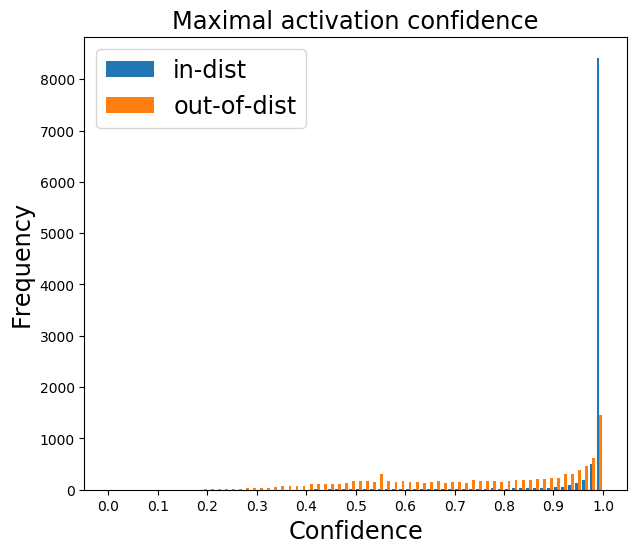

In [10]:
plt.figure(figsize=(7, 6), dpi=100) #, dpi=100
plt.title("Maximal activation confidence", fontsize='xx-large')
# plt.ylim(top=3000)
plt.hist([confidence, confidence_ood], bins=bin_dividers, label=['in-dist', 'out-of-dist'])
plt.xticks(np.linspace(0.0, 1.0, num=11))
plt.legend(fontsize='xx-large')
plt.ylabel("Frequency", fontsize='xx-large')
plt.xlabel("Confidence", fontsize='xx-large')
# plt.savefig("fig1.png")
plt.show()

0.9169096300000001


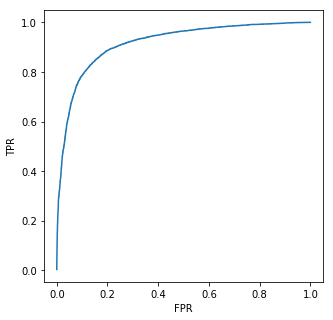

In [22]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

y_true = np.concatenate( ( np.ones(len(confidence)), np.zeros(len(confidence_ood)) ) )
y_score = np.concatenate((confidence, confidence_ood))
fpr, tpr, thresholds = roc_curve(y_true, y_score)
auc_metric = auc(fpr, tpr)

print(auc_metric)

plt.figure(figsize=(5,5))
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

## Using negative entropy as a confidence measure

In [12]:
from scipy.stats import entropy

neg_entropies = -np.apply_along_axis(entropy, 1, preds)
neg_entropies_ood = -np.apply_along_axis(entropy, 1, preds_ood)
print(neg_entropies.shape)

(10000,)


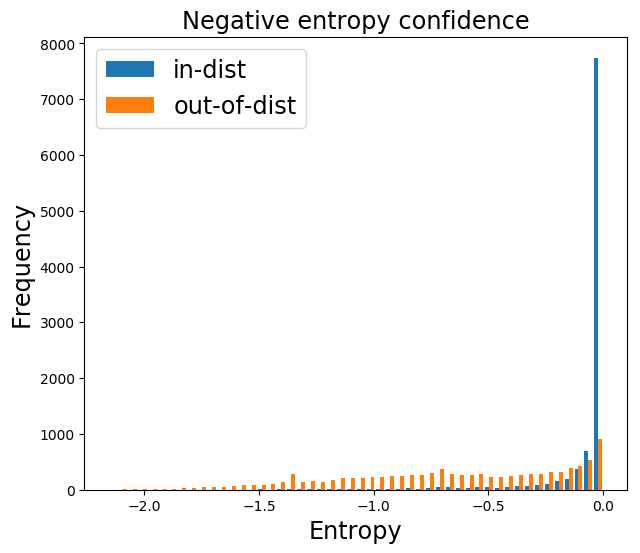

In [14]:
plt.figure(figsize=(7, 6), dpi=100)
plt.title("Negative entropy confidence", fontsize='xx-large')
plt.hist([neg_entropies, neg_entropies_ood], bins=50, label=['in-dist', 'out-of-dist'])
plt.legend(fontsize='xx-large')
plt.ylabel("Frequency", fontsize='xx-large')
plt.xlabel("Entropy", fontsize='xx-large')
# plt.tight_layout()
# plt.savefig("baselines/baseline_neg_ent_50.png")
plt.show()

0.91897184


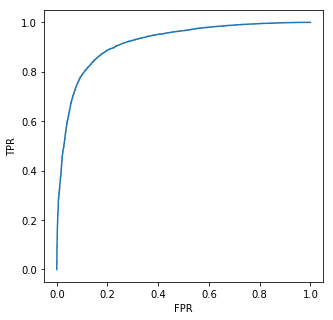

In [21]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

y_true = np.concatenate( ( np.ones(len(neg_entropies)), np.zeros(len(neg_entropies_ood)) ) )
y_score = np.concatenate((neg_entropies, neg_entropies_ood))
fpr, tpr, thresholds = roc_curve(y_true, y_score)
auc_metric = auc(fpr, tpr)

print(auc_metric)

plt.figure(figsize=(5,5))
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
# plt.savefig("baselines/roc_neg_ent.png")
plt.show()

## histogram intersection

In [16]:
def return_intersection(hist_1, hist_2):
    minima = np.minimum(hist_1, hist_2)
    intersection = np.true_divide(np.sum(minima), np.sum(hist_2))
    return intersection

In [17]:
hist1,bins=np.histogram(confidence)
hist2,bins=np.histogram(confidence_ood)

hist3,bins=np.histogram(neg_entropies)
hist4,bins=np.histogram(neg_entropies_ood)

print("maximal activation int:", return_intersection(hist1, hist2))
print("neg entropy int:", return_intersection(hist3, hist4))

maximal activation int: 0.4137
neg entropy int: 0.3611


In [14]:
from scipy import stats

print(stats.ttest_ind(confidence,confidence_ood))
print(stats.ttest_ind(neg_entropies,neg_entropies_ood))

Ttest_indResult(statistic=97.44322478069601, pvalue=0.0)
Ttest_indResult(statistic=112.61346249145548, pvalue=0.0)
